# House Prices (Ames) — EDA and Modeling Preparation

**Goal:** Explore the dataset, understand data quality, identify high-signal features, and define preprocessing/modeling choices for a reproducible pipeline.

Dataset: Kaggle “House Prices: Advanced Regression Techniques”
Target: `SalePrice` (regression)


In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Display settings (readable tables)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)


In [2]:

DATA_DIR = Path("../data/raw")

train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"

assert train_path.exists(), f"Missing file: {train_path}"
assert test_path.exists(), f"Missing file: {test_path}"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1) Basic checks
We verify schema, data types, duplicates, and confirm the target exists only in train.


In [3]:
# Target should exist in train only
assert "SalePrice" in train.columns, "SalePrice not found in train"
assert "SalePrice" not in test.columns, "SalePrice should not be in test"

print("Number of columns (train):", train.shape[1])
print("Number of columns (test):", test.shape[1])

# Duplicates
print("Duplicate rows in train:", train.duplicated().sum())
print("Duplicate rows in test:", test.duplicated().sum())

# Quick type breakdown
dtype_counts = train.dtypes.value_counts()
dtype_counts


Number of columns (train): 81
Number of columns (test): 80
Duplicate rows in train: 0
Duplicate rows in test: 0


object     43
int64      35
float64     3
dtype: int64

## 2) Target analysis (`SalePrice`)
We inspect distribution and skewness. Log-transform is common for this dataset.


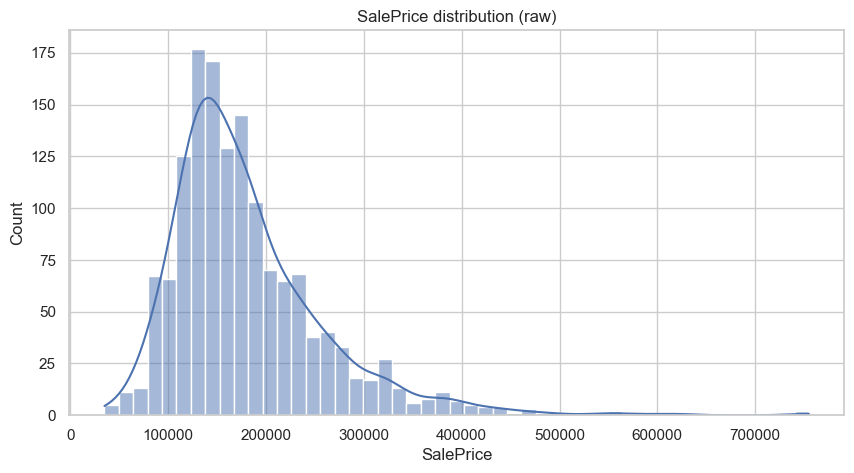

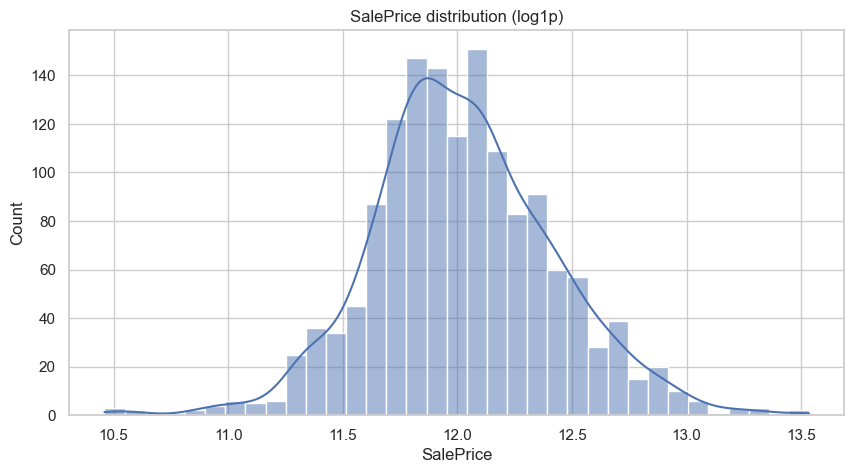

Skewness (raw):   1.8828757597682129
Skewness (log1p): 0.12134661989685333


In [4]:
# Raw distribution
sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice distribution (raw)")
plt.show()

# Log distribution (often closer to normal)
sns.histplot(np.log1p(train["SalePrice"]), kde=True)
plt.title("SalePrice distribution (log1p)")
plt.show()

# Skewness indicator (rough check)
print("Skewness (raw):  ", train["SalePrice"].skew())
print("Skewness (log1p):", np.log1p(train["SalePrice"]).skew())


## 3) Missing values
We quantify missingness and identify the columns that need imputation or special handling.


In [6]:
missing_count = train.isna().sum()
missing_pct = (missing_count / len(train)) * 100

missing_tbl = (
    pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
    .query("missing_count > 0")
    .sort_values("missing_pct", ascending=False)
)

missing_tbl.head(20)


,missing_count,missing_pct
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


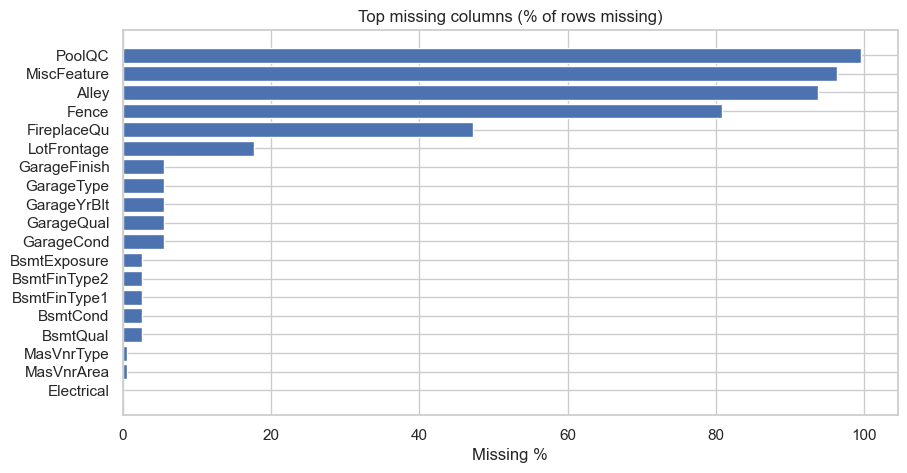

In [7]:
top_missing = missing_tbl.head(25).sort_values("missing_pct")
plt.barh(top_missing.index, top_missing["missing_pct"])
plt.title("Top missing columns (% of rows missing)")
plt.xlabel("Missing %")
plt.show()


## 4) Split features by type
This matters for preprocessing:
- Numeric: impute median
- Categorical: impute most-frequent + one-hot encoding


In [9]:
target = "SalePrice"

numeric_cols = train.drop(columns=[target]).select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train.drop(columns=[target]).select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

numeric_cols[:10], categorical_cols[:10]


Numeric columns: 37
Categorical columns: 43


(['Id',
  'MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1'],
 ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1'])

## 5) Numeric correlations with target
We identify high-signal numeric predictors.


In [11]:

corr = train[numeric_cols + [target]].corr()[target].sort_values(ascending=False)
corr.head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

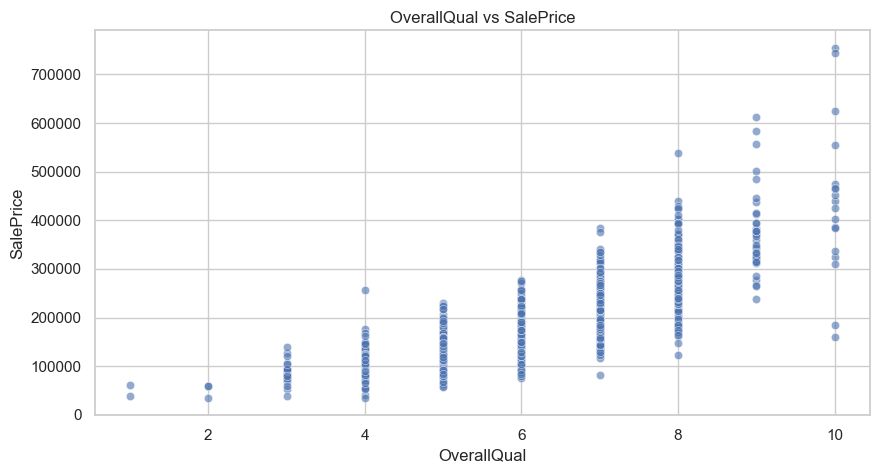

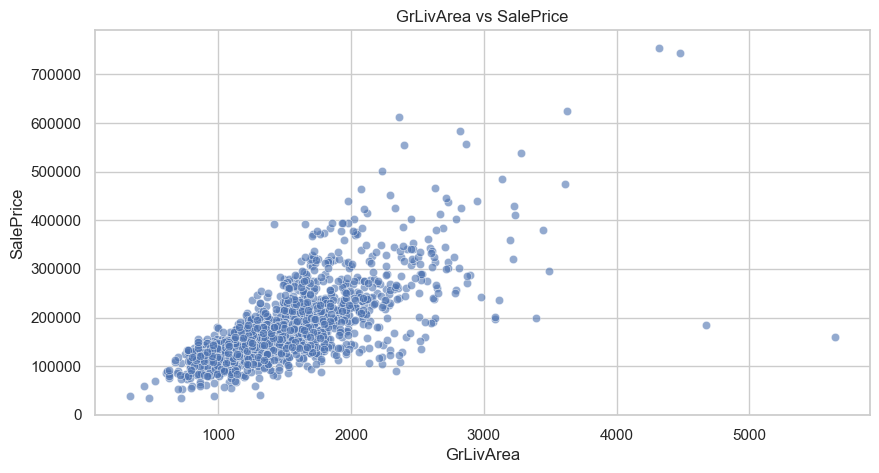

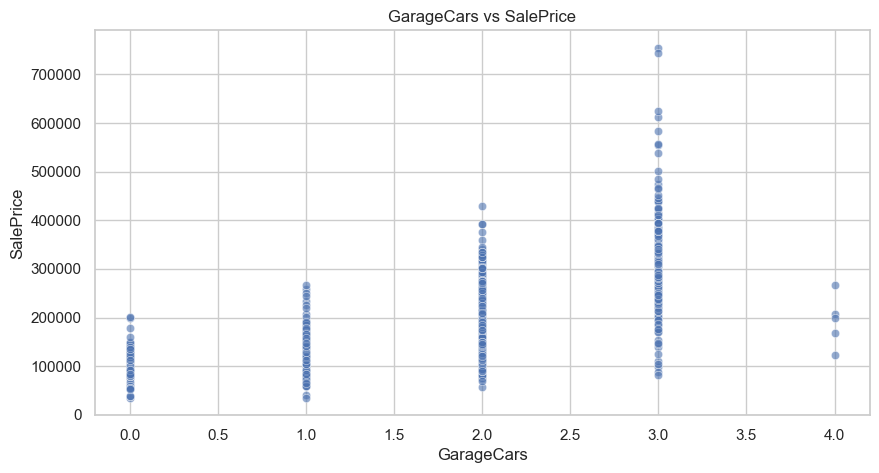

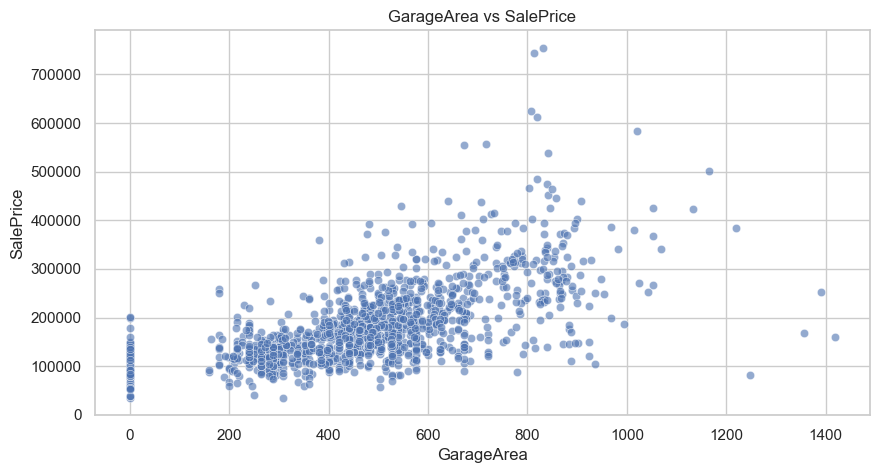

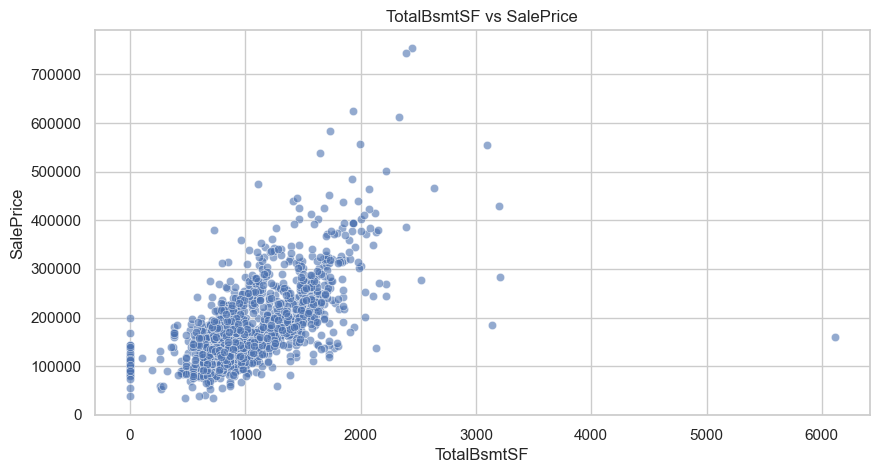

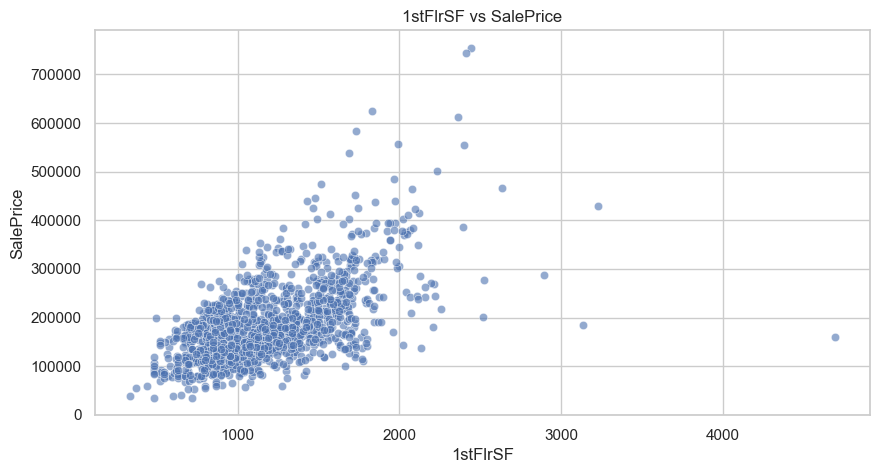

In [12]:
top_numeric = [c for c in corr.index if c != target][:6]

for col in top_numeric:
    sns.scatterplot(x=train[col], y=train[target], alpha=0.6)
    plt.title(f"{col} vs {target}")
    plt.show()


## 6) Categorical features vs target
We check a few categorical variables to see their impact on SalePrice.


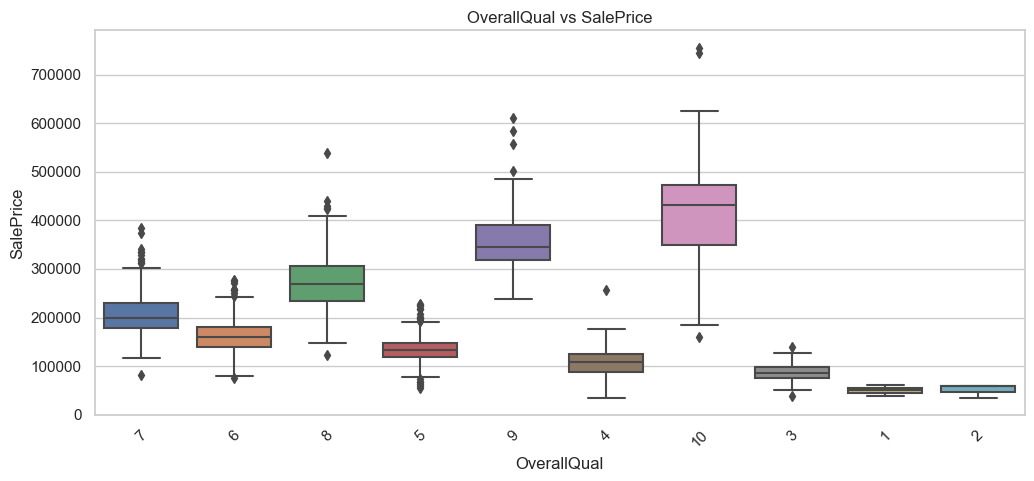

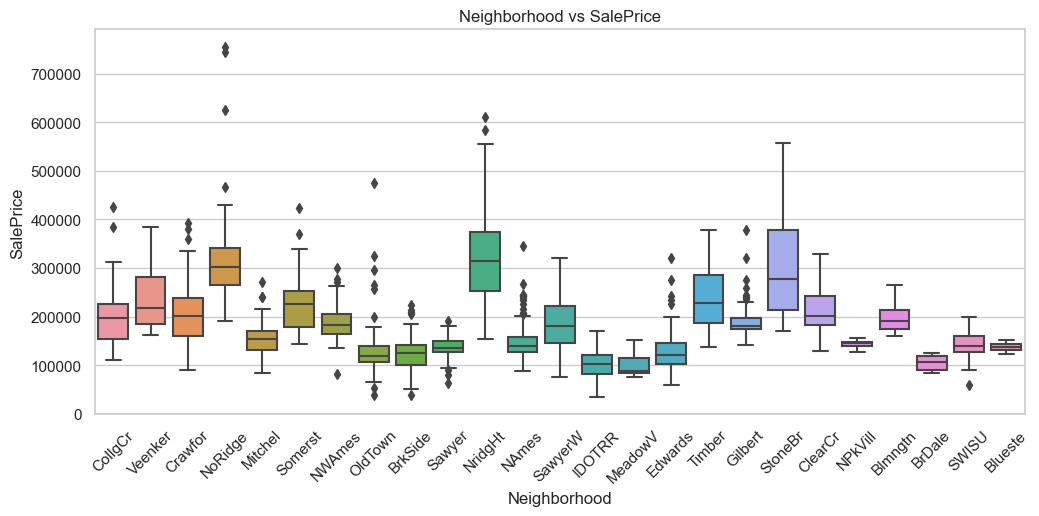

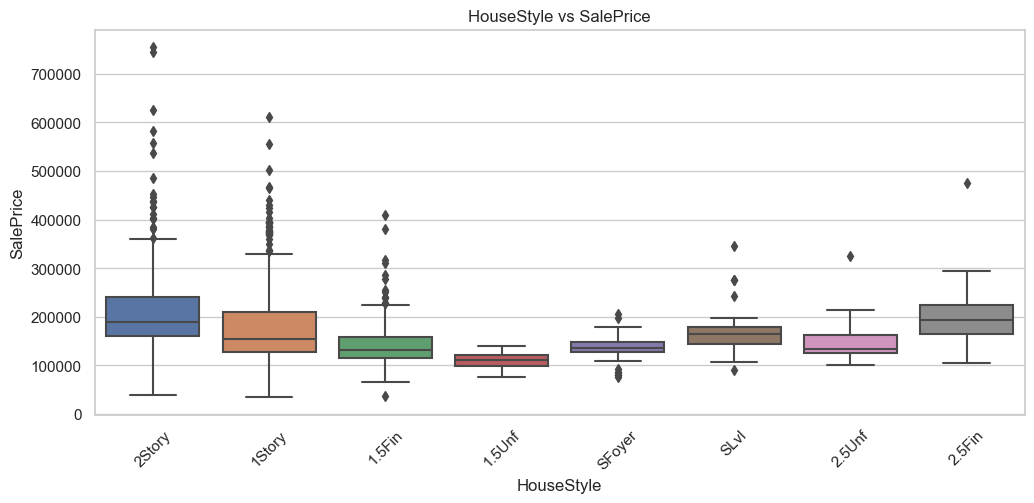

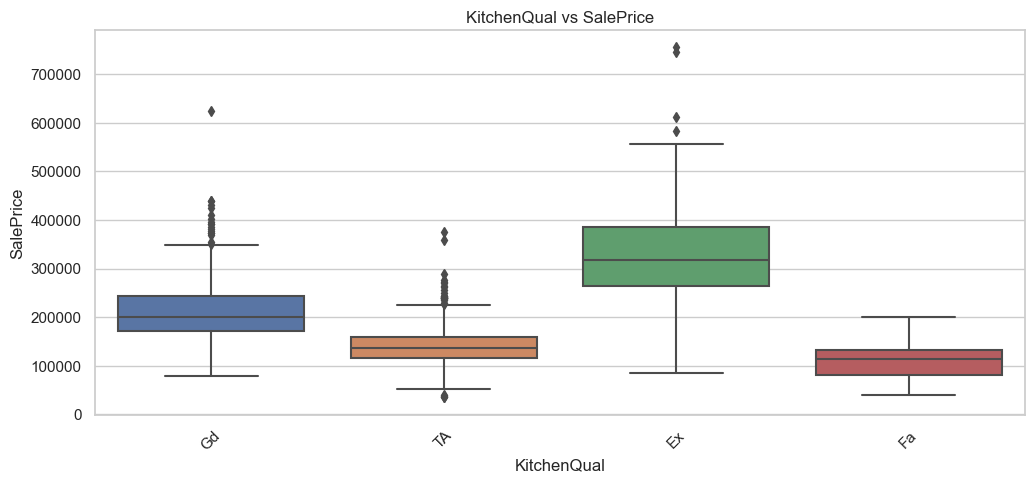

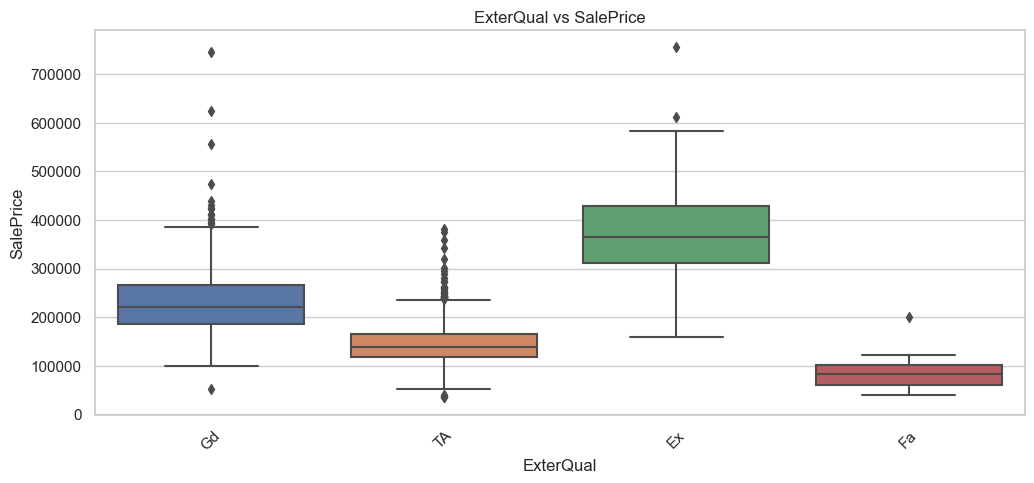

In [13]:
# Hand-picked common high-signal categoricals (exists in this dataset)
cat_candidates = ["OverallQual", "Neighborhood", "HouseStyle", "KitchenQual", "ExterQual"]

for col in cat_candidates:
    if col in train.columns:
        # If numeric but ordinal-like (OverallQual), still useful as boxplot
        plt.figure(figsize=(12, 5))
        sns.boxplot(x=train[col].astype(str), y=train[target])
        plt.title(f"{col} vs {target}")
        plt.xticks(rotation=45)
        plt.show()


## 7) Outliers check
Ames dataset is known to contain a few influential outliers (e.g., very large living area with low price).
We do a basic check for extreme values in high-signal features.


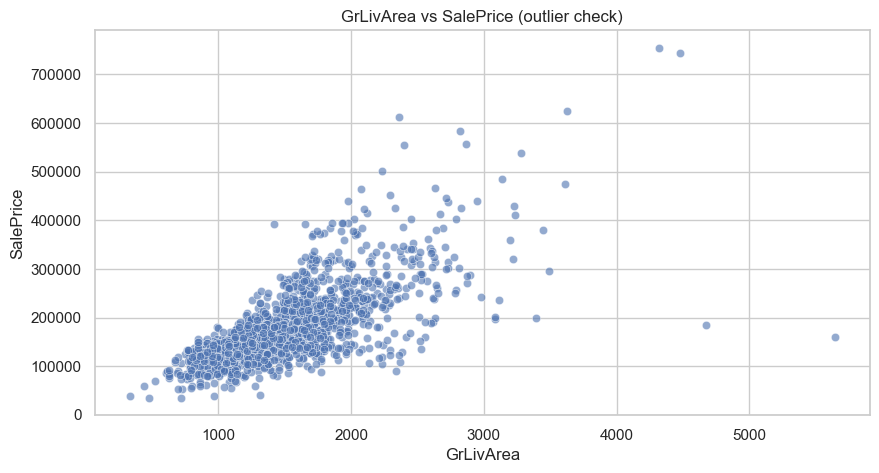

In [15]:
# Common outlier check: GrLivArea vs SalePrice (if present)
if "GrLivArea" in train.columns:
    sns.scatterplot(x=train["GrLivArea"], y=train[target], alpha=0.6)
    plt.title("GrLivArea vs SalePrice (outlier check)")
    plt.show()

    # Show top largest areas
    train.sort_values("GrLivArea", ascending=False)[["GrLivArea", target]].head(10)


## 8) EDA Summary (decisions for modeling pipeline)

**Target handling**
- `SalePrice` is right-skewed, so we will likely model `log1p(SalePrice)` for better regression performance.

**Preprocessing**
- Numeric: median imputation
- Categorical: most-frequent imputation + one-hot encoding
- Use `ColumnTransformer` within a `Pipeline` to prevent leakage

**Modeling plan (next)**
We will compare multiple models using cross-validation (RMSE):
- Baseline: Linear Regression
- Regularized: Ridge, Lasso
- Tree-based: RandomForest
- Boosting: GradientBoosting (or HistGradientBoosting)

We will select the best model by mean CV RMSE and save:
- `reports/metrics.json`
- `outputs/model.joblib`
- `outputs/submission.csv` (optional)


In [17]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Target present:", "SalePrice" in train.columns)
print("Target missing from test:", "SalePrice" not in test.columns)


Train shape: (1460, 81)
Test shape: (1459, 80)
Target present: True
Target missing from test: True
